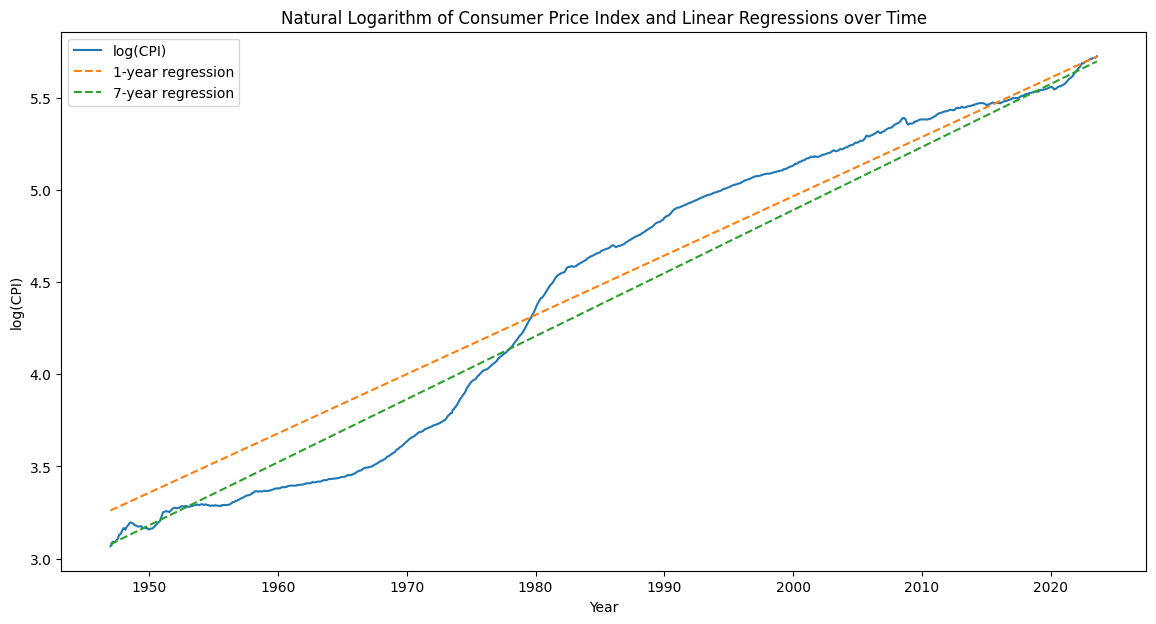

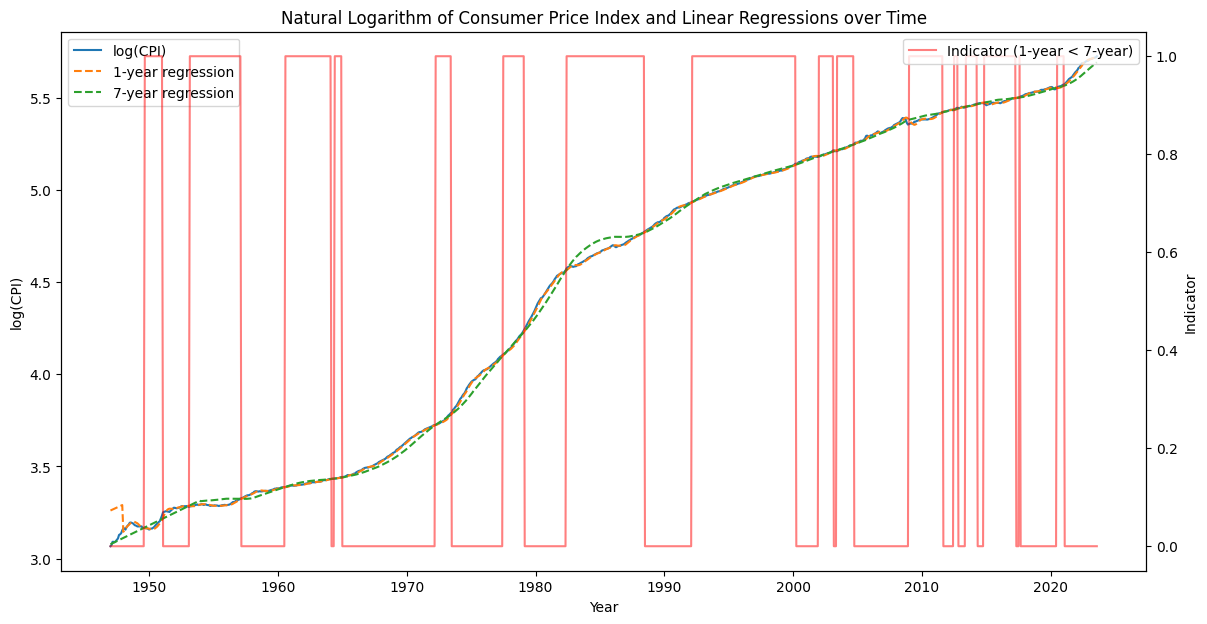

Latest indicator value:  0.0
[*********************100%***********************]  1 of 1 completed


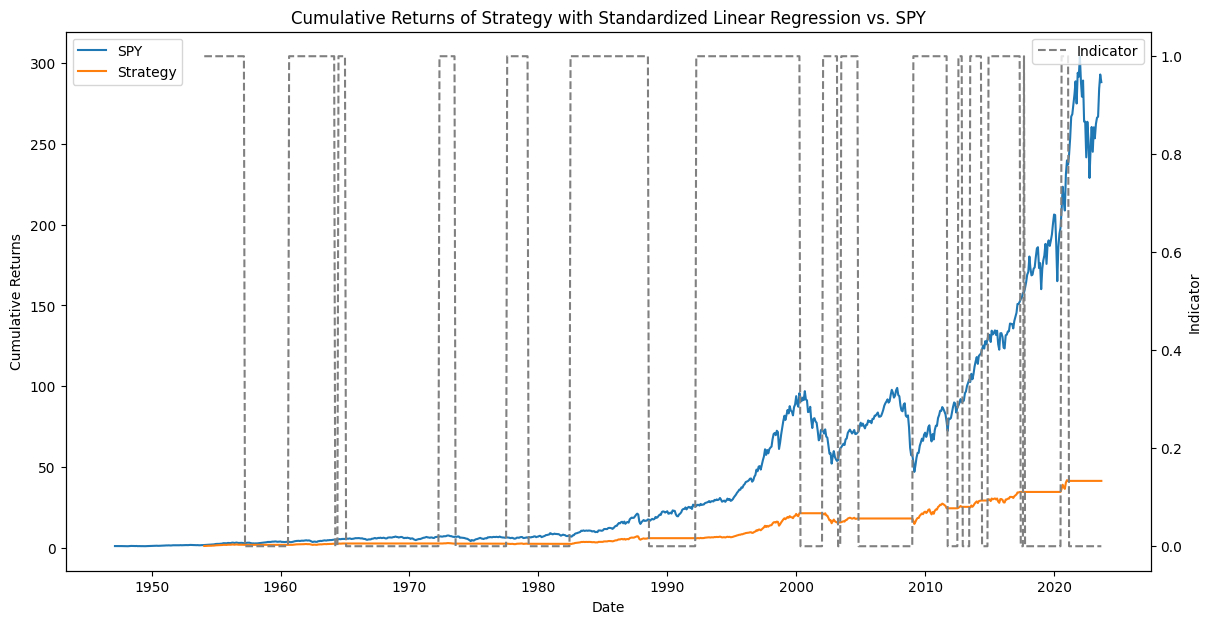

[*********************100%***********************]  1 of 1 completed


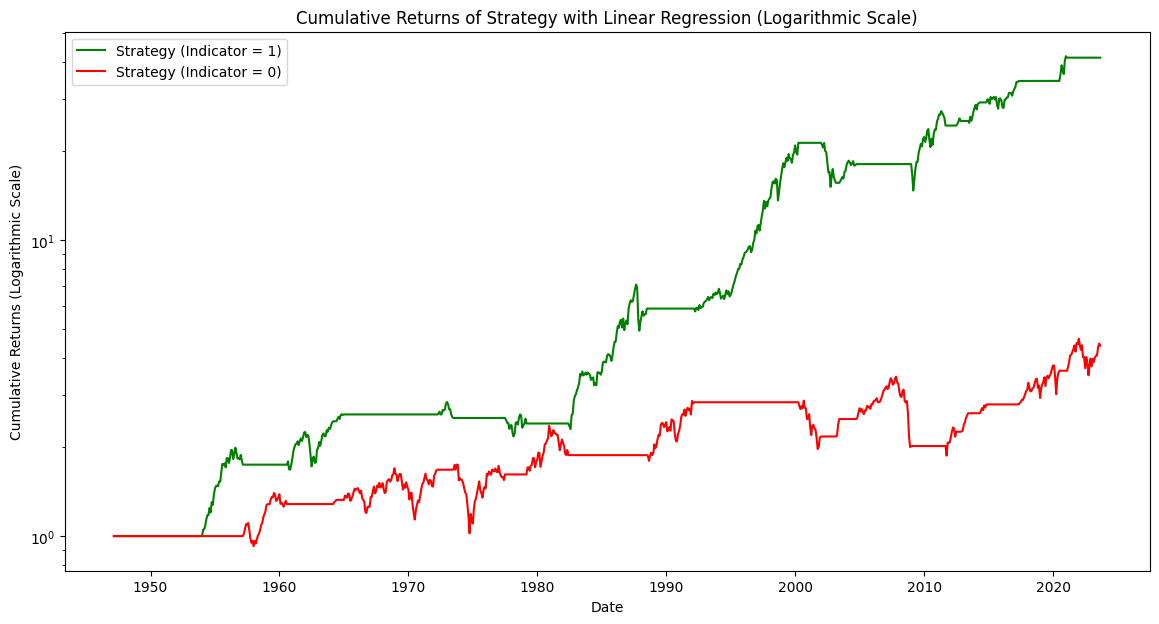

0.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import yfinance as yf

# Initialize the FRED API client (replace 'your_api_key_here' with your actual FRED API key)
fred = Fred(api_key='2f15c96b46530fde1b1992a64c64650e')

# Fetch Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
cpi_data = fred.get_series('CPIAUCSL')

# Convert the series into a DataFrame
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])

# Compute the natural logarithm of the CPI
cpi_df['log_CPI'] = np.log(cpi_df['CPI'])

# Linear regression model requires 2D array, so we'll convert our dates to numbers and reshape
X = cpi_df.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)  # independent variable (time)
y = cpi_df['log_CPI'].values  # dependent variable (log_CPI)

# Train the 1-year model
model_1 = LinearRegression()
model_1.fit(X[-12:], y[-12:])  # Use the last 12 months of data

# Train the 7-year model
model_7 = LinearRegression()
model_7.fit(X[-12*7:], y[-12*7:])  # Use the last 7*12 months of data

# Compute predictions
y_pred_1 = model_1.predict(X)
y_pred_7 = model_7.predict(X)

# Add predictions to the DataFrame
cpi_df['1_year_regression'] = y_pred_1
cpi_df['7_year_regression'] = y_pred_7

# Plot the natural log of the CPI data and the regressions
plt.figure(figsize=(14, 7))
plt.plot(cpi_df.index, cpi_df['log_CPI'], label='log(CPI)')
plt.plot(cpi_df.index, cpi_df['1_year_regression'], label='1-year regression', linestyle='--')
plt.plot(cpi_df.index, cpi_df['7_year_regression'], label='7-year regression', linestyle='--')
plt.title('Natural Logarithm of Consumer Price Index and Linear Regressions over Time')
plt.xlabel('Year')
plt.ylabel('log(CPI)')
plt.legend()
plt.show()

# Loop through each data point
for i in range(len(cpi_df)):
    
    # Check if there's enough data for the 1-year model
    if i >= 12:
        # Train the 1-year model
        model_1 = LinearRegression()
        X = cpi_df.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)[:i]  # independent variable (time)
        y = cpi_df['log_CPI'].values[:i]  # dependent variable (log_CPI)
        model_1.fit(X[-12:], y[-12:])  # Use the last 12 months of data
        # Predict for the current point
        cpi_df.loc[cpi_df.index[i], '1_year_regression'] = model_1.predict([X[-1]])
    
    # Check if there's enough data for the 7-year model
    if i >= 12 * 7:
        # Train the 7-year model
        model_7 = LinearRegression()
        model_7.fit(X[-12*7:], y[-12*7:])  # Use the last 7*12 months of data
        # Predict for the current point
        cpi_df.loc[cpi_df.index[i], '7_year_regression'] = model_7.predict([X[-1]])
    
    # Compute the indicator
    if not np.isnan(cpi_df.loc[cpi_df.index[i], '1_year_regression']) and not np.isnan(cpi_df.loc[cpi_df.index[i], '7_year_regression']):
        cpi_df.loc[cpi_df.index[i], 'indicator'] = int(cpi_df.loc[cpi_df.index[i], '1_year_regression'] < cpi_df.loc[cpi_df.index[i], '7_year_regression'])

# Plot the natural log of the CPI data, the regressions, and the indicator
plt.figure(figsize=(14, 7))
plt.plot(cpi_df.index, cpi_df['log_CPI'], label='log(CPI)')
plt.plot(cpi_df.index, cpi_df['1_year_regression'], label='1-year regression', linestyle='--')
plt.plot(cpi_df.index, cpi_df['7_year_regression'], label='7-year regression', linestyle='--')
plt.title('Natural Logarithm of Consumer Price Index and Linear Regressions over Time')
plt.xlabel('Year')
plt.ylabel('log(CPI)')
plt.legend(loc='upper left')
plt.twinx()
plt.plot(cpi_df.index, cpi_df['indicator'], label='Indicator (1-year < 7-year)', color='red', alpha=0.5)
plt.ylabel('Indicator')
plt.legend(loc='upper right')
plt.show()

print("Latest indicator value: ", cpi_df['indicator'].iloc[-1])



# Initialize the FRED API client
fred = Fred(api_key='2f15c96b46530fde1b1992a64c64650e')  # Replace with your FRED API key

# Fetch Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
cpi_data = fred.get_series('CPIAUCSL')

# Convert the series into a DataFrame
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])

# Compute the natural logarithm of the CPI
cpi_df['log_CPI'] = np.log(cpi_df['CPI'])

# Merge datasets
combined_df = cpi_df.resample('M').last().fillna(method='ffill')

# Fetch historical data for SPY (daily data)
spy_data_daily = yf.download('^GSPC', start=combined_df.index[0], end=combined_df.index[-1])
spy_data = spy_data_daily['Adj Close'].resample('M').last()

# Compute daily returns
combined_df['spy_returns'] = spy_data.pct_change()

# Compute the indicator for each data point
for i in range(12*7, len(combined_df)):
    X = combined_df.index[:i].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    y = combined_df['log_CPI'].iloc[:i].values

    # Standardize X
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    model_1 = LinearRegression()
    model_1.fit(X[-12:], y[-12:])
    
    model_7 = LinearRegression()
    model_7.fit(X[-12*7:], y[-12*7:])
    
    y_pred_1 = model_1.predict(X[-12:])
    y_pred_7 = model_7.predict(X[-12*7:])
    
    combined_df.loc[combined_df.index[i], 'indicator'] = 1 if y_pred_7[-1] > y_pred_1[-1] else 0

# Compute strategy returns
combined_df['strategy_returns'] = combined_df['spy_returns'] * combined_df['indicator']

# Compute cumulative returns
combined_df['cumulative_spy_returns'] = (1 + combined_df['spy_returns']).cumprod()
combined_df['cumulative_strategy_returns'] = (1 + combined_df['strategy_returns']).cumprod()

# Plot the cumulative returns
fig, ax1 = plt.subplots(figsize=(14, 7))

ax2 = ax1.twinx()
ax1.plot(combined_df.index, combined_df['cumulative_spy_returns'], label='SPY')
ax1.plot(combined_df.index, combined_df['cumulative_strategy_returns'], label='Strategy')
ax2.plot(combined_df.index, combined_df['indicator'], label='Indicator', linestyle='--', color='gray')

ax1.set_title('Cumulative Returns of Strategy with Standardized Linear Regression vs. SPY')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Returns')
ax2.set_ylabel('Indicator')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


# Initialize the FRED API client
fred = Fred(api_key='2f15c96b46530fde1b1992a64c64650e')  # Replace with your FRED API key

# Fetch Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
cpi_data = fred.get_series('CPIAUCSL')

# Convert the series into a DataFrame
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])

# Compute the natural logarithm of the CPI
cpi_df['log_CPI'] = np.log(cpi_df['CPI'])

# Merge datasets
combined_df = cpi_df.resample('M').last().fillna(method='ffill')

# Fetch historical data for SPY (daily data)
spy_data_daily = yf.download('^GSPC', start=combined_df.index[0], end=combined_df.index[-1])
spy_data = spy_data_daily['Close'].resample('M').last()

# Compute daily returns
combined_df['spy_returns'] = spy_data.pct_change()

# Compute the indicator for each data point
for i in range(12*7, len(combined_df)):
    X = combined_df.index[:i].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    y = combined_df['log_CPI'].iloc[:i].values
    
    model_1 = LinearRegression()
    model_1.fit(X[-12:], y[-12:])
    
    model_7 = LinearRegression()
    model_7.fit(X[-12*7:], y[-12*7:])
    
    y_pred_1 = model_1.predict([X[i-1]])
    y_pred_7 = model_7.predict([X[i-1]])
    
    combined_df.loc[combined_df.index[i], 'indicator'] = 1 if y_pred_7[-1] > y_pred_1[-1] else 0

# Compute strategy returns when indicator is 1 and 0
combined_df['strategy_returns_indicator_1'] = combined_df['spy_returns'] * (combined_df['indicator'] == 1)
combined_df['strategy_returns_indicator_0'] = combined_df['spy_returns'] * (combined_df['indicator'] == 0)

# Compute cumulative returns when indicator is 1 and 0
combined_df['cumulative_strategy_returns_indicator_1'] = (1 + combined_df['strategy_returns_indicator_1']).cumprod()
combined_df['cumulative_strategy_returns_indicator_0'] = (1 + combined_df['strategy_returns_indicator_0']).cumprod()

# Plot the cumulative returns in logarithmic scale
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(combined_df.index, combined_df['cumulative_strategy_returns_indicator_1'], label='Strategy (Indicator = 1)', color='green')
ax.plot(combined_df.index, combined_df['cumulative_strategy_returns_indicator_0'], label='Strategy (Indicator = 0)', color='red')
ax.set_yscale('log')  # Set y-axis to logarithmic scale
ax.set_title('Cumulative Returns of Strategy with Linear Regression (Logarithmic Scale)')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns (Logarithmic Scale)')

ax.legend(loc='upper left')

plt.show()

print(combined_df['indicator'].iloc[-1])